### Study the back-propagation algorithm. Implement a classifier for the loan data with Decision as the output attribute. Prepare the data as needed. Submit the notebook file.

Training set shape: (379, 35)
Test set shape: (95, 35)
Epoch 1/50
38/38 [==============================] - 1s 7ms/step - loss: 0.6454 - accuracy: 0.6148 - val_loss: 0.5978 - val_accuracy: 0.7263
Epoch 2/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5555 - accuracy: 0.7150 - val_loss: 0.5446 - val_accuracy: 0.6842
Epoch 3/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5035 - accuracy: 0.7599 - val_loss: 0.4967 - val_accuracy: 0.7474
Epoch 4/50
38/38 [==============================] - 0s 2ms/step - loss: 0.4565 - accuracy: 0.8127 - val_loss: 0.4848 - val_accuracy: 0.7368
Epoch 5/50
38/38 [==============================] - 0s 3ms/step - loss: 0.4264 - accuracy: 0.8153 - val_loss: 0.4713 - val_accuracy: 0.7684
Epoch 6/50
38/38 [==============================] - 0s 3ms/step - loss: 0.4089 - accuracy: 0.8206 - val_loss: 0.4676 - val_accuracy: 0.7684
Epoch 7/50
38/38 [==============================] - 0s 3ms/step - loss: 0.3866 - accuracy: 0.8443 - val_l

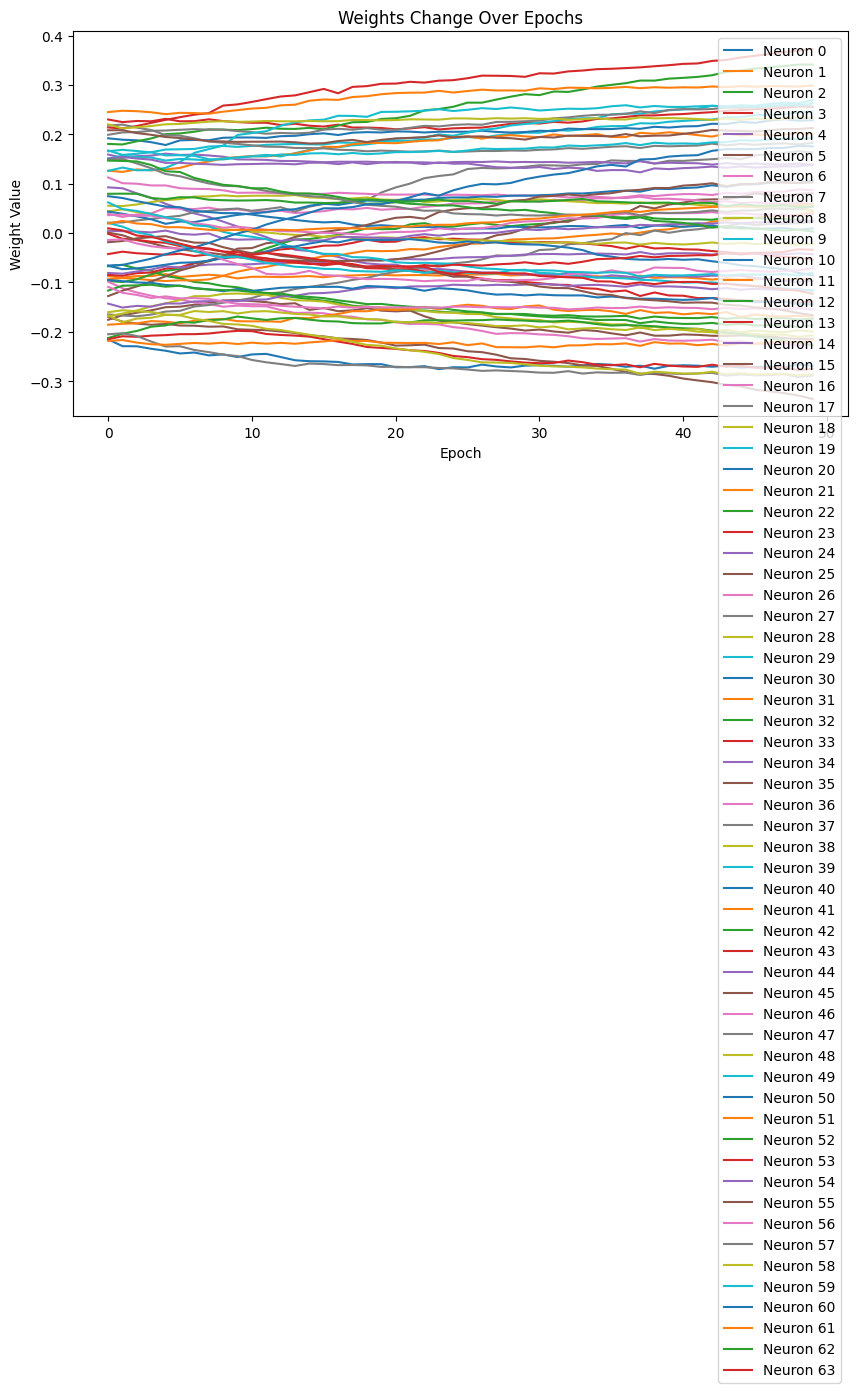

3/3 - 0s - loss: 0.6830 - accuracy: 0.8316 - 26ms/epoch - 9ms/step

Test accuracy: 0.8315789699554443
3/3 [==============================] - 0s 1ms/step
[[0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]]
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        43
           1       0.85      0.85      0.85        52

    accuracy                           0.83        95
   macro avg       0.83      0.83      0.83        95
weighted avg       0.83      0.83      0.83        95



In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

class WeightsHistory(Callback):
    def on_train_begin(self, logs={}):
        self.weights = []

    def on_epoch_end(self, epoch, logs={}):
        self.weights.append(self.model.layers[0].get_weights()[0])

    def on_train_end(self, logs={}):
        weights = np.array(self.weights)
        plt.figure(figsize=(10, 5))
        for i in range(weights.shape[2]):
            plt.plot(weights[:, 0, i], label=f'Neuron {i}')
        plt.title('Weights Change Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Weight Value')
        plt.legend()
        plt.show()

# Load the dataset
loan_data = pd.read_excel('R:/NEU/SEM4-FALL/Generative-AI/data/loan.xlsx')

# Data Cleaning: Ensure all string data is consistently formatted
loan_data = loan_data.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)

# Identify categorical and numerical columns
categorical_cols = ['Sex', 'Res_status', 'Telephone', 'Occupation', 'Job_status', 'Liab_ref', 'Acc_ref']
numerical_cols = ['Age', 'Time_at_address', 'Time_employed', 'Time_bank', 'Home_Expn', 'Balance']

# Define a pipeline for numerical data processing``
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define a pipeline for categorical data processing
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine numerical and categorical pipelines into a ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Apply preprocessing to features
X = loan_data.drop('Decision', axis=1)
y = loan_data['Decision'].map({'accept': 1, 'reject': 0})  # Encode the target variable

X_prepared = preprocessor.fit_transform(X)

# Data Balancing: Address class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_prepared, y)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Output the processed data shape
print(f'Training set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')

# Assume X_balanced and y_balanced are already defined from previous preprocessing steps
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
# Initialize the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    Dense(32, activation='relu'),  # Hidden layer
    Dense(1, activation='sigmoid')  # Output layer
])

# Compile the model
model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

weight_history = WeightsHistory()

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=10, 
    validation_data=(X_test, y_test), 
    callbacks=[weight_history],
    verbose=1
)
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
# Predict classes
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)

# Print some of the predictions
print(predictions[:10])

# Detailed classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))
